# Model Building

In [1]:
from platform import python_version
print(python_version())

3.10.9


In [2]:
#Import the required Libraries
import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
raw_data = pd.read_csv("Trady Flow - Best Options Trade Ideas.csv")
pd.options.display.max_columns = None
raw_data.head()

,Time,Sym,C/P,Exp,Strike,Spot,BidAsk,Orders,Vol,Prems,OI,Diff(%),ITM
0,6/17/2022 15:07,ISEE,Call,10/21/2022,10.0,9.54,5.05,7,360,183.60K,4.07K,4.71,0
1,6/17/2022 15:05,CVNA,Call,1/19/2024,60.0,23.52,4.60,7,634,310.66K,130,155.05,0
2,6/17/2022 14:51,PTLO,Put,2/17/2023,15.0,15.19,3.50,7,800,281.00K,0,1.39,0
3,6/17/2022 14:39,TWLO,Call,6/24/2022,86.0,84.51,2.95,5,722,198.80K,436,2.48,0
4,6/17/2022 13:56,ATUS,Put,9/16/2022,7.0,8.62,0.68,5,6.27K,501.84K,8.63K,23.13,0


In [4]:
raw_data['Date'] = pd.to_datetime(raw_data['Time']).dt.date

In [5]:
raw_data.head()

,Time,Sym,C/P,Exp,Strike,Spot,BidAsk,Orders,Vol,Prems,OI,Diff(%),ITM,Date
0,6/17/2022 15:07,ISEE,Call,10/21/2022,10.0,9.54,5.05,7,360,183.60K,4.07K,4.71,0,2022-06-17
1,6/17/2022 15:05,CVNA,Call,1/19/2024,60.0,23.52,4.60,7,634,310.66K,130,155.05,0,2022-06-17
2,6/17/2022 14:51,PTLO,Put,2/17/2023,15.0,15.19,3.50,7,800,281.00K,0,1.39,0,2022-06-17
3,6/17/2022 14:39,TWLO,Call,6/24/2022,86.0,84.51,2.95,5,722,198.80K,436,2.48,0,2022-06-17
4,6/17/2022 13:56,ATUS,Put,9/16/2022,7.0,8.62,0.68,5,6.27K,501.84K,8.63K,23.13,0,2022-06-17


In [6]:
raw_data.shape

(7827, 14)

In [7]:
raw_data.groupby('Sym').size()

Sym
A         2
AA       41
AAL      57
AAPL     48
ABBV     19
ABC       1
ABCL      1
ABNB     16
ABT       4
ABUS      1
ACAD      1
ACB       1
ACI       1
ACM       1
ACMR      6
ACN       4
ACWI      1
ADBE      8
ADI      19
ADM       1
ADNT      1
ADP       1
ADS       4
ADSK      2
ADT       1
AEHR      1
AEM       4
AEO      11
AER       2
AES       4
AFRM     47
AG        3
AGC       3
AHT       2
AI        5
AIG       2
AKAM     18
ALB       5
ALEC      1
ALGN      1
ALGT      4
ALK       3
ALL       1
ALLY      3
ALNY      2
AMAT     17
AMBA      2
AMC      30
AMCX      1
AMD      50
AMED      1
AMGN     10
AMRS      1
AMT       2
AMZN     30
AN        2
ANF       5
ANTM      2
ANY       3
AON       4
AOUT      3
APA       8
APLS      1
APO       1
APP       1
APPS      6
APSG      1
AR       18
ARCT      1
ARE       1
ARKG      3
ARKK     23
ARNC      5
ARQQ      2
ARRY      3
ARVL      4
ARVN      2
ARWR      1
ASAN      5
ASHR      1
ASLE      1
ASML      2
ASO      20


#### Renaming columns

In [8]:
raw_data.rename(columns={raw_data.columns[1]: 'Symbols', raw_data.columns[2]: 'Option_type', raw_data.columns[3]: 'Expiry', raw_data.columns[4]: 'Strike_price', raw_data.columns[5]: 'Spot_price', raw_data.columns[8]: 'Volume', raw_data.columns[9]: 'Premium'},inplace=True)
raw_data.head()

,Time,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,OI,Diff(%),ITM,Date
0,6/17/2022 15:07,ISEE,Call,10/21/2022,10.0,9.54,5.05,7,360,183.60K,4.07K,4.71,0,2022-06-17
1,6/17/2022 15:05,CVNA,Call,1/19/2024,60.0,23.52,4.60,7,634,310.66K,130,155.05,0,2022-06-17
2,6/17/2022 14:51,PTLO,Put,2/17/2023,15.0,15.19,3.50,7,800,281.00K,0,1.39,0,2022-06-17
3,6/17/2022 14:39,TWLO,Call,6/24/2022,86.0,84.51,2.95,5,722,198.80K,436,2.48,0,2022-06-17
4,6/17/2022 13:56,ATUS,Put,9/16/2022,7.0,8.62,0.68,5,6.27K,501.84K,8.63K,23.13,0,2022-06-17


#### Handling Datatypes

In [9]:
raw_data['Expiry'] = pd.to_datetime(raw_data['Expiry']).dt.date
raw_data['Date'] = pd.to_datetime(raw_data['Date']).dt.date
raw_data.head()

,Time,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,OI,Diff(%),ITM,Date
0,6/17/2022 15:07,ISEE,Call,2022-10-21,10.0,9.54,5.05,7,360,183.60K,4.07K,4.71,0,2022-06-17
1,6/17/2022 15:05,CVNA,Call,2024-01-19,60.0,23.52,4.60,7,634,310.66K,130,155.05,0,2022-06-17
2,6/17/2022 14:51,PTLO,Put,2023-02-17,15.0,15.19,3.50,7,800,281.00K,0,1.39,0,2022-06-17
3,6/17/2022 14:39,TWLO,Call,2022-06-24,86.0,84.51,2.95,5,722,198.80K,436,2.48,0,2022-06-17
4,6/17/2022 13:56,ATUS,Put,2022-09-16,7.0,8.62,0.68,5,6.27K,501.84K,8.63K,23.13,0,2022-06-17


In [10]:
raw_data.dtypes

Time             object
Symbols          object
Option_type      object
Expiry           object
Strike_price    float64
Spot_price      float64
BidAsk          float64
Orders            int64
Volume           object
Premium          object
OI               object
Diff(%)         float64
ITM               int64
Date             object
dtype: object

In [11]:
repl_dict = {'[kK]': '*1e3', '[mM]': '*1e6', '[bB]': '*1e9', }
raw_data['Volume'] = raw_data['Volume'].replace(repl_dict, regex=True).map(pd.eval)
raw_data['Premium'] = raw_data['Premium'].replace(repl_dict, regex=True).map(pd.eval)

In [12]:
raw_data.dtypes

Time             object
Symbols          object
Option_type      object
Expiry           object
Strike_price    float64
Spot_price      float64
BidAsk          float64
Orders            int64
Volume          float64
Premium         float64
OI               object
Diff(%)         float64
ITM               int64
Date             object
dtype: object

In [13]:
raw_data.describe()

,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),ITM
count,7827.000000,7827.000000,7827.000000,7827.000000,7827.000000,7.827000e+03,7827.000000,7827.000000
mean,151.178342,148.595490,4.220649,7.109493,2740.656573,7.189672e+05,11.477625,0.679826
std,358.668235,353.566766,5.207856,5.312003,4931.768058,1.484765e+06,19.367772,0.466573
min,1.500000,1.230000,0.110000,5.000000,250.000000,1.252500e+05,0.020000,0.000000
25%,30.000000,28.270000,1.650000,5.000000,708.000000,2.388650e+05,2.110000,0.000000
50%,60.000000,58.950000,3.100000,5.000000,1310.000000,3.676300e+05,5.600000,1.000000
75%,145.000000,145.160000,5.120000,7.000000,2810.000000,6.749750e+05,12.715000,1.000000
max,3950.000000,3755.250000,194.350000,124.000000,131530.000000,6.235000e+07,277.640000,1.000000


#### Dropping insignificant columns from the data

In [14]:
raw_data = raw_data.drop(['Time','OI','ITM'], 1)
raw_data.head()

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date
0,ISEE,Call,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17
1,CVNA,Call,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17
2,PTLO,Put,2023-02-17,15.0,15.19,3.50,7,800.0,281000.0,1.39,2022-06-17
3,TWLO,Call,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17
4,ATUS,Put,2022-09-16,7.0,8.62,0.68,5,6270.0,501840.0,23.13,2022-06-17


In [15]:
raw_data.describe()

,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%)
count,7827.000000,7827.000000,7827.000000,7827.000000,7827.000000,7.827000e+03,7827.000000
mean,151.178342,148.595490,4.220649,7.109493,2740.656573,7.189672e+05,11.477625
std,358.668235,353.566766,5.207856,5.312003,4931.768058,1.484765e+06,19.367772
min,1.500000,1.230000,0.110000,5.000000,250.000000,1.252500e+05,0.020000
25%,30.000000,28.270000,1.650000,5.000000,708.000000,2.388650e+05,2.110000
50%,60.000000,58.950000,3.100000,5.000000,1310.000000,3.676300e+05,5.600000
75%,145.000000,145.160000,5.120000,7.000000,2810.000000,6.749750e+05,12.715000
max,3950.000000,3755.250000,194.350000,124.000000,131530.000000,6.235000e+07,277.640000


In [16]:
raw_data.shape

(7827, 11)

#### Filter the dataset only for "Call"

In [17]:
df_call = raw_data.loc[(raw_data['Option_type'] == 'Call')]
df_call.head()

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date
0,ISEE,Call,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17
1,CVNA,Call,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17
3,TWLO,Call,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17
8,ET,Call,2024-01-19,10.0,9.84,1.53,6,1200.0,186160.0,1.75,2022-06-17
9,WFC,Call,2024-01-19,40.0,38.31,6.15,5,250.0,152250.0,4.98,2022-06-17


In [18]:
# Replacing 'Call' value with 'c' for Implied Volatility calculation
df_call['Option_type'] = df_call['Option_type'].replace('Call','c')

In [19]:
df_call.head()

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date
0,ISEE,c,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17
1,CVNA,c,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17
3,TWLO,c,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17
8,ET,c,2024-01-19,10.0,9.84,1.53,6,1200.0,186160.0,1.75,2022-06-17
9,WFC,c,2024-01-19,40.0,38.31,6.15,5,250.0,152250.0,4.98,2022-06-17


In [20]:
df_call.dtypes

Symbols          object
Option_type      object
Expiry           object
Strike_price    float64
Spot_price      float64
BidAsk          float64
Orders            int64
Volume          float64
Premium         float64
Diff(%)         float64
Date             object
dtype: object

In [21]:
df_call.isnull().sum()

Symbols         0
Option_type     0
Expiry          0
Strike_price    0
Spot_price      0
BidAsk          0
Orders          0
Volume          0
Premium         0
Diff(%)         0
Date            0
dtype: int64

#### Calculating 'Time_to_Expiry' col
Time_to_Expiry = Expiry - Date / 250 (Market functioning days)

In [22]:
df_call['Days_diff'] = (df_call['Expiry'] - df_call['Date']).dt.days
df_call.head()

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date,Days_diff
0,ISEE,c,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17,126
1,CVNA,c,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17,581
3,TWLO,c,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17,7
8,ET,c,2024-01-19,10.0,9.84,1.53,6,1200.0,186160.0,1.75,2022-06-17,581
9,WFC,c,2024-01-19,40.0,38.31,6.15,5,250.0,152250.0,4.98,2022-06-17,581


In [23]:
df_call['Time_to_Expiry'] = (df_call['Days_diff']/250)
df_call.head()

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date,Days_diff,Time_to_Expiry
0,ISEE,c,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17,126,0.504
1,CVNA,c,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17,581,2.324
3,TWLO,c,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17,7,0.028
8,ET,c,2024-01-19,10.0,9.84,1.53,6,1200.0,186160.0,1.75,2022-06-17,581,2.324
9,WFC,c,2024-01-19,40.0,38.31,6.15,5,250.0,152250.0,4.98,2022-06-17,581,2.324


#### Compute volatility using Pandas rolling and std methods, the trading days is set to 365 days

TRADING_DAYS = 365
returns = np.log(raw_data['Spot']/raw_data['Spot'].shift(1))
returns.fillna(0, inplace=True)
volatility = returns.rolling(window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS)
volatility.tail()

%matplotlib inline
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility')
ax1.set_title('Annualized volatility for input-Raw data')
plt.show()

TRADING_DAYS = 365
returns = np.log(raw_data['Spot']/raw_data['Spot'].shift(1))
returns.fillna(0, inplace=True)
raw_data["volatility"] = returns.rolling(window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS)
raw_data.tail()

raw_data.shape

raw_data.describe()

raw_data["volatility"].isnull().sum()

raw_data["volatility"].isnull().sum()/len(raw_data) * 100

### Calculationg Implied Volatility of Stock Option

In [24]:
df_call.dtypes

Symbols            object
Option_type        object
Expiry             object
Strike_price      float64
Spot_price        float64
BidAsk            float64
Orders              int64
Volume            float64
Premium           float64
Diff(%)           float64
Date               object
Days_diff           int64
Time_to_Expiry    float64
dtype: object

In [25]:
df_call['BidAsk']

0       5.05
1       4.60
3       2.95
8       1.53
9       6.15
        ... 
7819    5.50
7820    0.89
7822    4.62
7823    1.38
7826    5.40
Name: BidAsk, Length: 5077, dtype: float64

price = df_call['BidAsk']
s = df_call['Spot_price']
k = df_call['Strike_price']
t = df_call['Time_to_Expiry']
r = 0
q = 0
flag = 'c'

price = 5.05
s = 9.54
k = 10.0
t = 0.504
r = 0
q = 0
flag = 'c'

iv = implied_volatility(price, s, k, t, r, q, flag)
print(iv)

- <b>price</b>: The option's market price.
- s: The current price of the stock.
- k: The option's strike price.
- t: The time until expiration, expressed in years.
- r: The risk-free interest rate, expressed as a decimal.
- q: annualized continuous dividend rate.
- flag: A string indicating whether the option is a call option ('c') or a put option ('p').

https://stackoverflow.com/questions/61289020/fast-implied-volatility-calculation-in-python

import numpy as np
from scipy.stats import norm
N = norm.cdf

def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 200
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

In [26]:
df_call.describe()

,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Days_diff,Time_to_Expiry
count,5077.000000,5077.000000,5077.000000,5077.000000,5077.000000,5.077000e+03,5077.000000,5077.000000,5077.000000
mean,164.266939,155.124824,4.056494,7.295647,2801.577112,7.029790e+05,11.661036,113.250148,0.453001
std,392.983901,380.989119,4.429347,6.049169,4983.100369,1.475597e+06,21.035417,147.217554,0.588870
min,1.500000,1.230000,0.110000,5.000000,250.000000,1.252500e+05,0.020000,0.000000,0.000000
25%,30.000000,27.020000,1.520000,5.000000,756.000000,2.364600e+05,1.940000,21.000000,0.084000
50%,62.500000,57.350000,2.930000,5.000000,1390.000000,3.639100e+05,5.200000,53.000000,0.212000
75%,152.500000,147.080000,5.050000,7.000000,2940.000000,6.661800e+05,12.060000,150.000000,0.600000
max,3950.000000,3755.250000,72.900000,124.000000,131530.000000,6.235000e+07,267.290000,850.000000,3.400000


S = df_call['Strike_price']
K = df_call['Spot_price']
T = df_call['Time_to_Expiry']
r = 0
vol = df_call['Volume']

V_market = bs_call(S, K, T, r, vol)
implied_vol = find_vol(V_market, S, K, T, r)

print ('Implied vol: %.2f%%' % (implied_vol * 100))
print ('Market price = %.2f' % V_market)
print ('Model price = %.2f' % bs_call(S, K, T, r, implied_vol))

In [27]:
import py_vollib.black_scholes.implied_volatility as iv

# Define a function to calculate implied volatility
def calculate_implied_volatility(row):
    S = row['Spot_price']
    K = row['Strike_price']
    r = 0  # Risk-free interest rate (set to 0 for simplicity)
    t = row['Time_to_Expiry']
    price = row['BidAsk']
    option_type = row['Option_type']
    
    try:
        implied_volatility = iv.implied_volatility(price, S, K, t, r, option_type)
    except:
        implied_volatility = None
    
    return implied_volatility

# Apply the function to calculate implied volatility for each row in the DataFrame
df_call['Implied_Volatility'] = df_call.apply(calculate_implied_volatility, axis=1)

In [28]:
df_call['Implied_Volatility'].value_counts

<bound method IndexOpsMixin.value_counts of 0       2.082404
1       0.754821
3       0.641070
8       0.268521
9       0.294886
          ...   
7819    0.719506
7820    1.054175
7822    0.228837
7823    0.610646
7826    0.392591
Name: Implied_Volatility, Length: 5077, dtype: float64>

In [29]:
df_call.head()

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date,Days_diff,Time_to_Expiry,Implied_Volatility
0,ISEE,c,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17,126,0.504,2.082404
1,CVNA,c,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17,581,2.324,0.754821
3,TWLO,c,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17,7,0.028,0.641070
8,ET,c,2024-01-19,10.0,9.84,1.53,6,1200.0,186160.0,1.75,2022-06-17,581,2.324,0.268521
9,WFC,c,2024-01-19,40.0,38.31,6.15,5,250.0,152250.0,4.98,2022-06-17,581,2.324,0.294886


In [30]:
df_call.describe()

,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Days_diff,Time_to_Expiry,Implied_Volatility
count,5077.000000,5077.000000,5077.000000,5077.000000,5077.000000,5.077000e+03,5077.000000,5077.000000,5077.000000,5076.000000
mean,164.266939,155.124824,4.056494,7.295647,2801.577112,7.029790e+05,11.661036,113.250148,0.453001,inf
std,392.983901,380.989119,4.429347,6.049169,4983.100369,1.475597e+06,21.035417,147.217554,0.588870,NaN
min,1.500000,1.230000,0.110000,5.000000,250.000000,1.252500e+05,0.020000,0.000000,0.000000,0.071907
25%,30.000000,27.020000,1.520000,5.000000,756.000000,2.364600e+05,1.940000,21.000000,0.084000,0.269261
50%,62.500000,57.350000,2.930000,5.000000,1390.000000,3.639100e+05,5.200000,53.000000,0.212000,0.396793
75%,152.500000,147.080000,5.050000,7.000000,2940.000000,6.661800e+05,12.060000,150.000000,0.600000,0.588207
max,3950.000000,3755.250000,72.900000,124.000000,131530.000000,6.235000e+07,267.290000,850.000000,3.400000,inf


In [31]:
df_call.dtypes

Symbols                object
Option_type            object
Expiry                 object
Strike_price          float64
Spot_price            float64
BidAsk                float64
Orders                  int64
Volume                float64
Premium               float64
Diff(%)               float64
Date                   object
Days_diff               int64
Time_to_Expiry        float64
Implied_Volatility    float64
dtype: object

https://medium.datadriveninvestor.com/black-scholes-and-option-greeks-in-python-6038f184801e
- **Delta** : Measures Impact of a Change in the Price of Underlying [https://www.investopedia.com/terms/d/delta.asp]
- **Gamma**: Measures the Rate of Change of Delta
- **Theta**: Measures Impact of a Change in Time Remaining
- **Vega**: Measures Impact of a Change in Volatility 
- **Rho**: Measures the impact of changes in Interest rates

In [32]:
import numpy as np
from scipy.stats import norm

def calculate_delta(row):
    S = row['Spot_price']  # Spot price
    K = row['Strike_price']  # Strike price
    r = 0  # Risk-free interest rate 
    T = row['Time_to_Expiry']  # Time to expiry in years
    sigma = row['Implied_Volatility']  # Implied volatility

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)

    if row['Option_type'] == 'put':
        delta -= 1  # Adjust delta for put options

    return delta

# Apply the delta calculation function to each row in the DataFrame
df_call['Delta'] = df_call.apply(calculate_delta, axis=1)

df_call.head(5)

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date,Days_diff,Time_to_Expiry,Implied_Volatility,Delta
0,ISEE,c,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17,126,0.504,2.082404,0.760318
1,CVNA,c,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17,581,2.324,0.754821,0.405748
3,TWLO,c,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17,7,0.028,0.641070,0.456486
8,ET,c,2024-01-19,10.0,9.84,1.53,6,1200.0,186160.0,1.75,2022-06-17,581,2.324,0.268521,0.565635
9,WFC,c,2024-01-19,40.0,38.31,6.15,5,250.0,152250.0,4.98,2022-06-17,581,2.324,0.294886,0.551220


In [33]:
import py_vollib
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks import analytical

# Assuming your dataframe is called df_call
for index, row in df_call.iterrows():
    S = row['Spot_price']  # Spot price
    K = row['Strike_price']  # Strike price
    r = 0  # Risk-free interest rate (assumed to be 0 for simplicity)
    t = row['Days_diff'] / 365 # Time to expiry in years
    sigma = row['Implied_Volatility']  # Implied volatility
    option_type = row['Option_type']  # Option type (either 'call' or 'put')

    # Calculate the Delta using the analytical method
    delta_new = analytical.delta('call', S, K, t, r, sigma)
    
    # Assign the calculated Delta value to the dataframe
    df_call.loc[index, 'Delta_new'] = delta_new


In [34]:
df_call.head()

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date,Days_diff,Time_to_Expiry,Implied_Volatility,Delta,Delta_new
0,ISEE,c,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17,126,0.504,2.082404,0.760318,0.716766
1,CVNA,c,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17,581,2.324,0.754821,0.405748,0.306003
3,TWLO,c,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17,7,0.028,0.641070,0.456486,0.439406
8,ET,c,2024-01-19,10.0,9.84,1.53,6,1200.0,186160.0,1.75,2022-06-17,581,2.324,0.268521,0.565635,0.548464
9,WFC,c,2024-01-19,40.0,38.31,6.15,5,250.0,152250.0,4.98,2022-06-17,581,2.324,0.294886,0.551220,0.527900


In [35]:
import numpy as np
from scipy.stats import norm

# Constants
risk_free_rate = 0  # Example value, replace with your own
df_call['Time_to_Expiry'] = df_call['Time_to_Expiry']

# Calculate Vega
df_call['Vega'] = df_call['Spot_price'] * np.exp(-risk_free_rate * df_call['Time_to_Expiry']) * norm.pdf(df_call['Implied_Volatility']) * np.sqrt(df_call['Time_to_Expiry'])

In [36]:
df_call.head()

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date,Days_diff,Time_to_Expiry,Implied_Volatility,Delta,Delta_new,Vega
0,ISEE,c,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17,126,0.504,2.082404,0.760318,0.716766,0.309055
1,CVNA,c,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17,581,2.324,0.754821,0.405748,0.306003,10.758329
3,TWLO,c,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17,7,0.028,0.641070,0.456486,0.439406,4.593630
8,ET,c,2024-01-19,10.0,9.84,1.53,6,1200.0,186160.0,1.75,2022-06-17,581,2.324,0.268521,0.565635,0.548464,5.772530
9,WFC,c,2024-01-19,40.0,38.31,6.15,5,250.0,152250.0,4.98,2022-06-17,581,2.324,0.294886,0.551220,0.527900,22.307845


To calculate Vega in Python for the given DataFrame df_call

Vega = Spot_price * e^(-r * T) * N'(d1) * sqrt(T)

Where:

Spot_price is the current price of the underlying asset.
r is the risk-free interest rate.
T is the time to expiry in years.
N'(d1) is the standard normal probability density function evaluated at d1.
d1 is the input of the cumulative distribution function for the standard normal distribution.

In [37]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def calculate_option_price(row):
    S = row['Spot_price']
    K = row['Strike_price']
    T = row['Time_to_Expiry']
    r = 0.05  # Risk-free interest rate
    sigma = row['Implied_Volatility']
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return call_price

# Load the dataframe and preprocess the data

# Assuming the dataframe is named 'df'
df_call['Option_call_price'] = df_call.apply(calculate_option_price, axis=1)

In [38]:
df_call.head()

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date,Days_diff,Time_to_Expiry,Implied_Volatility,Delta,Delta_new,Vega,Option_call_price
0,ISEE,c,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17,126,0.504,2.082404,0.760318,0.716766,0.309055,5.105461
1,CVNA,c,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17,581,2.324,0.754821,0.405748,0.306003,10.758329,5.194151
3,TWLO,c,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17,7,0.028,0.641070,0.456486,0.439406,4.593630,3.000150
8,ET,c,2024-01-19,10.0,9.84,1.53,6,1200.0,186160.0,1.75,2022-06-17,581,2.324,0.268521,0.565635,0.548464,5.772530,2.032843
9,WFC,c,2024-01-19,40.0,38.31,6.15,5,250.0,152250.0,4.98,2022-06-17,581,2.324,0.294886,0.551220,0.527900,22.307845,8.007376


https://medium.datadriveninvestor.com/black-scholes-and-option-greeks-in-python-6038f184801e

https://pypi.org/project/opstrat/

pip install opstrat

#Import Libraries
import opstrat as op

#Declare parameters

K=200    #spot price
St=208   #current stock price
r=4      #4% risk free rate
t=30     #time to expiry, 30 days 
v=20     #volatility 
type='c' #Option type call

#Black Scholes Model
bsm=op.black_scholes(K=K, St=St, r=r, t=t, 
                     v=v, type='c')

bsm['value']

bsm['value']['option value']

In [39]:
%matplotlib inline

import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen #Johansen Cointegration test

In [40]:
df_call.head()

,Symbols,Option_type,Expiry,Strike_price,Spot_price,BidAsk,Orders,Volume,Premium,Diff(%),Date,Days_diff,Time_to_Expiry,Implied_Volatility,Delta,Delta_new,Vega,Option_call_price
0,ISEE,c,2022-10-21,10.0,9.54,5.05,7,360.0,183600.0,4.71,2022-06-17,126,0.504,2.082404,0.760318,0.716766,0.309055,5.105461
1,CVNA,c,2024-01-19,60.0,23.52,4.60,7,634.0,310660.0,155.05,2022-06-17,581,2.324,0.754821,0.405748,0.306003,10.758329,5.194151
3,TWLO,c,2022-06-24,86.0,84.51,2.95,5,722.0,198800.0,2.48,2022-06-17,7,0.028,0.641070,0.456486,0.439406,4.593630,3.000150
8,ET,c,2024-01-19,10.0,9.84,1.53,6,1200.0,186160.0,1.75,2022-06-17,581,2.324,0.268521,0.565635,0.548464,5.772530,2.032843
9,WFC,c,2024-01-19,40.0,38.31,6.15,5,250.0,152250.0,4.98,2022-06-17,581,2.324,0.294886,0.551220,0.527900,22.307845,8.007376


df_call.index = df_call.Date
df_call.head()

In [41]:
df_call.dtypes

Symbols                object
Option_type            object
Expiry                 object
Strike_price          float64
Spot_price            float64
BidAsk                float64
Orders                  int64
Volume                float64
Premium               float64
Diff(%)               float64
Date                   object
Days_diff               int64
Time_to_Expiry        float64
Implied_Volatility    float64
Delta                 float64
Delta_new             float64
Vega                  float64
Option_call_price     float64
dtype: object

In [42]:
df_call.isnull().sum()

Symbols                0
Option_type            0
Expiry                 0
Strike_price           0
Spot_price             0
BidAsk                 0
Orders                 0
Volume                 0
Premium                0
Diff(%)                0
Date                   0
Days_diff              0
Time_to_Expiry         0
Implied_Volatility     1
Delta                 25
Delta_new             25
Vega                   1
Option_call_price     25
dtype: int64

In [43]:
df_call = df_call.dropna(axis=0, subset=["Option_call_price"])
df_call["Option_call_price"].isnull().sum()/len(raw_data) * 100

0.0

In [44]:
df_call.isnull().sum()

Symbols               0
Option_type           0
Expiry                0
Strike_price          0
Spot_price            0
BidAsk                0
Orders                0
Volume                0
Premium               0
Diff(%)               0
Date                  0
Days_diff             0
Time_to_Expiry        0
Implied_Volatility    0
Delta                 0
Delta_new             0
Vega                  0
Option_call_price     0
dtype: int64

In [45]:
df_call.shape

(5052, 18)

#### Train-Test split

In [46]:
df_call = df_call.drop(['Symbols','Option_type','Expiry','Volume','Premium','Delta','Delta_new','Vega'], 1)
df_call.head()

,Strike_price,Spot_price,BidAsk,Orders,Diff(%),Date,Days_diff,Time_to_Expiry,Implied_Volatility,Option_call_price
0,10.0,9.54,5.05,7,4.71,2022-06-17,126,0.504,2.082404,5.105461
1,60.0,23.52,4.60,7,155.05,2022-06-17,581,2.324,0.754821,5.194151
3,86.0,84.51,2.95,5,2.48,2022-06-17,7,0.028,0.641070,3.000150
8,10.0,9.84,1.53,6,1.75,2022-06-17,581,2.324,0.268521,2.032843
9,40.0,38.31,6.15,5,4.98,2022-06-17,581,2.324,0.294886,8.007376


In [47]:
df_call

,Strike_price,Spot_price,BidAsk,Orders,Diff(%),Date,Days_diff,Time_to_Expiry,Implied_Volatility,Option_call_price
0,10.0,9.54,5.05,7,4.71,2022-06-17,126,0.504,2.082404,5.105461
1,60.0,23.52,4.60,7,155.05,2022-06-17,581,2.324,0.754821,5.194151
3,86.0,84.51,2.95,5,2.48,2022-06-17,7,0.028,0.641070,3.000150
8,10.0,9.84,1.53,6,1.75,2022-06-17,581,2.324,0.268521,2.032843
9,40.0,38.31,6.15,5,4.98,2022-06-17,581,2.324,0.294886,8.007376
...,...,...,...,...,...,...,...,...,...,...
7819,295.0,249.21,5.50,6,20.56,2021-06-07,18,0.072,0.719506,5.678415
7820,15.0,11.60,0.89,10,28.54,2021-06-07,39,0.156,1.054175,0.914148
7822,57.5,56.78,4.62,7,1.23,2021-06-07,228,0.912,0.228837,5.836899
7823,21.0,19.72,1.38,6,5.34,2021-06-07,39,0.156,0.610646,1.438329


In [48]:
df_call = df_call.reset_index(drop=True)

In [49]:
df_call

,Strike_price,Spot_price,BidAsk,Orders,Diff(%),Date,Days_diff,Time_to_Expiry,Implied_Volatility,Option_call_price
0,10.0,9.54,5.05,7,4.71,2022-06-17,126,0.504,2.082404,5.105461
1,60.0,23.52,4.60,7,155.05,2022-06-17,581,2.324,0.754821,5.194151
2,86.0,84.51,2.95,5,2.48,2022-06-17,7,0.028,0.641070,3.000150
3,10.0,9.84,1.53,6,1.75,2022-06-17,581,2.324,0.268521,2.032843
4,40.0,38.31,6.15,5,4.98,2022-06-17,581,2.324,0.294886,8.007376
...,...,...,...,...,...,...,...,...,...,...
5047,295.0,249.21,5.50,6,20.56,2021-06-07,18,0.072,0.719506,5.678415
5048,15.0,11.60,0.89,10,28.54,2021-06-07,39,0.156,1.054175,0.914148
5049,57.5,56.78,4.62,7,1.23,2021-06-07,228,0.912,0.228837,5.836899
5050,21.0,19.72,1.38,6,5.34,2021-06-07,39,0.156,0.610646,1.438329


In [50]:
df_call.shape

(5052, 10)

In [51]:
df_call.describe()

,Strike_price,Spot_price,BidAsk,Orders,Diff(%),Days_diff,Time_to_Expiry,Implied_Volatility,Option_call_price
count,5052.000000,5052.000000,5052.000000,5052.000000,5052.000000,5052.00000,5052.000000,5052.000000,5052.000000
mean,160.943537,151.792017,4.057637,7.289786,11.714076,113.81057,0.455242,0.492267,4.608949
std,385.000276,372.811403,4.432901,6.033493,21.073768,147.36514,0.589461,0.366559,5.218136
min,1.500000,1.230000,0.110000,5.000000,0.020000,1.00000,0.004000,0.071907,0.130563
25%,30.000000,26.927500,1.520000,5.000000,1.980000,21.00000,0.084000,0.268827,1.691078
50%,62.500000,57.080000,2.930000,5.000000,5.235000,53.00000,0.212000,0.395013,3.273051
75%,150.000000,146.170000,5.050000,7.000000,12.100000,151.50000,0.606000,0.585226,5.652311
max,3950.000000,3755.250000,72.900000,124.000000,267.290000,850.00000,3.400000,5.098801,84.974520


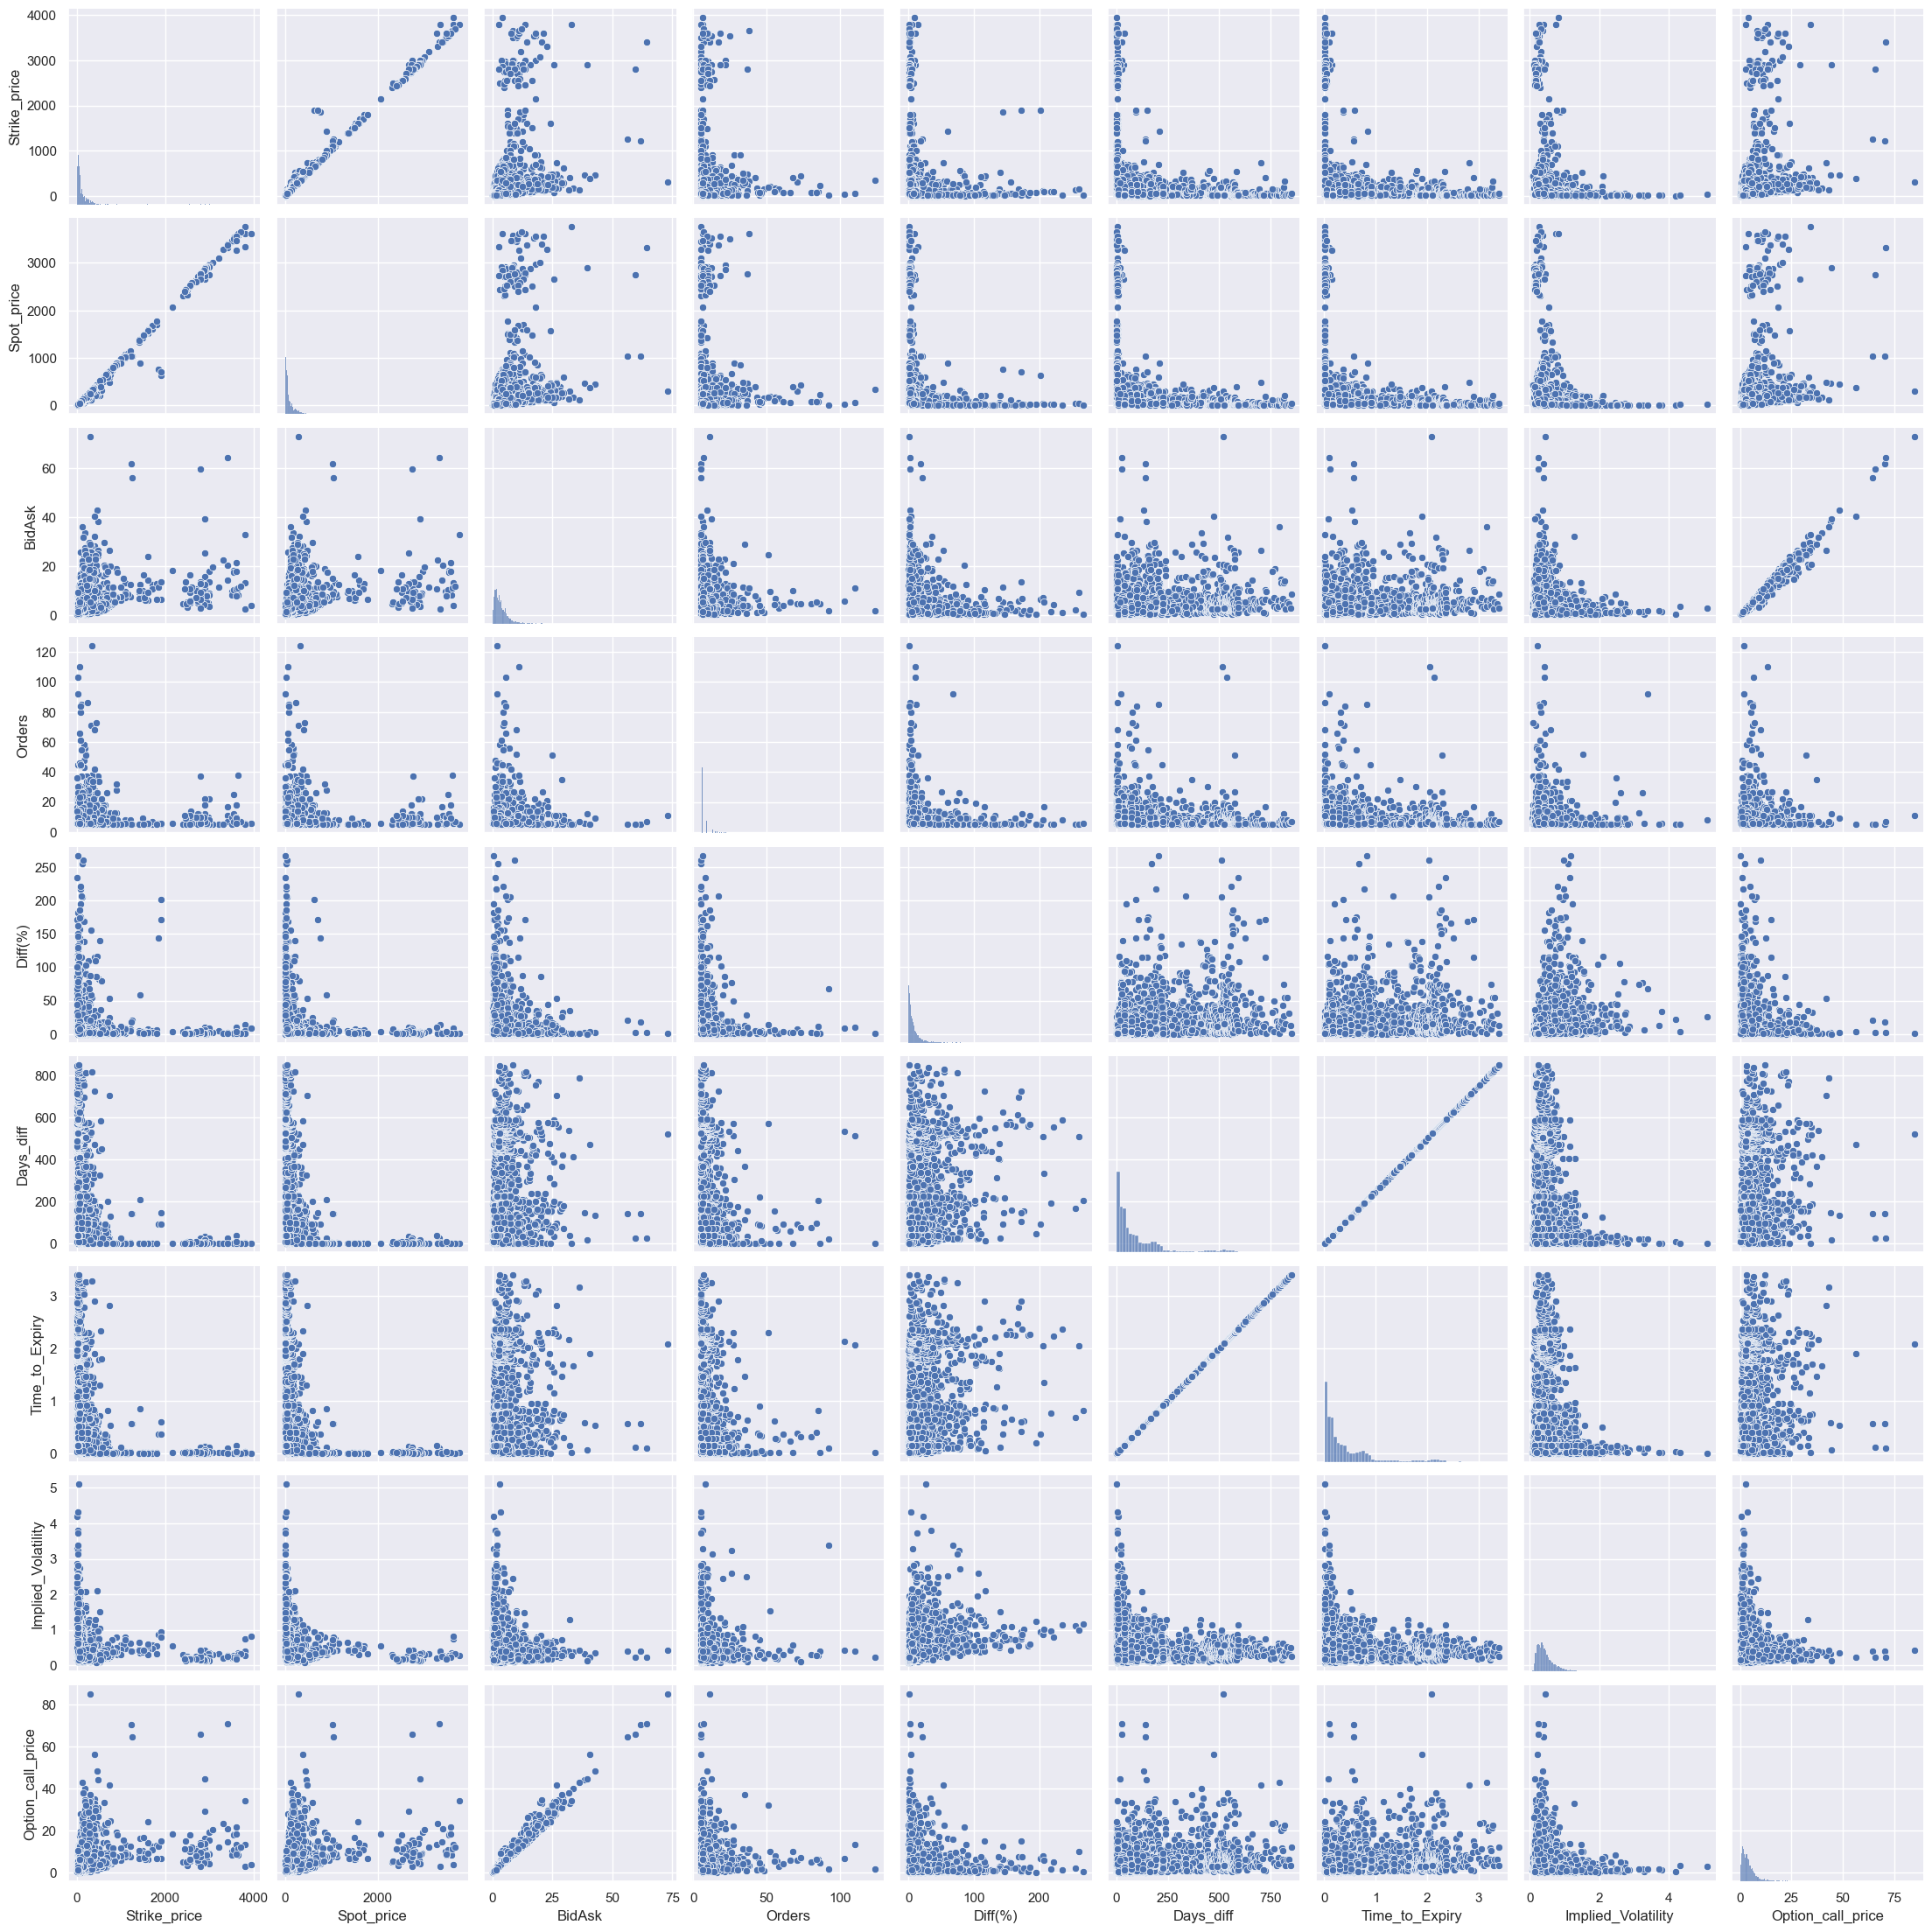

In [52]:
sns.pairplot(df_call)
plt.show()

<Axes: >

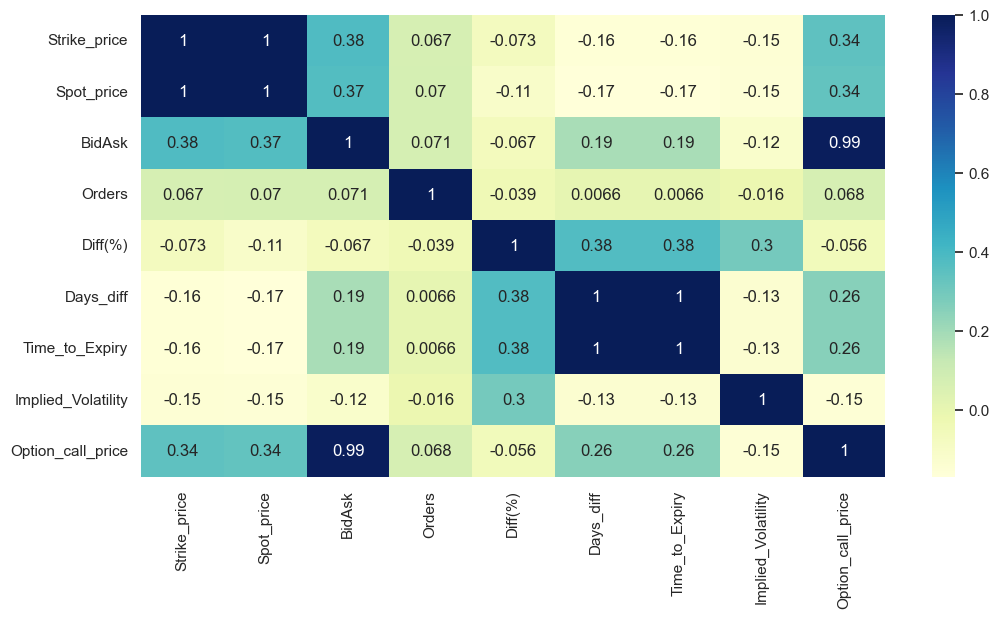

In [53]:
# Correlation

import seaborn as sns
import matplotlib.pyplot as plt

# get correlations of each pair of features in the data
corrmat = df_call.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12, 6))

# plot heat map
sns.heatmap(df_call[top_corr_features].corr(), annot=True, cmap="YlGnBu")

In [54]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(df_call, train_size = 0.7, test_size = 0.3, random_state = 0)

In [55]:
df_train.shape

(3536, 10)

In [56]:
df_test.shape

(1516, 10)

#### Rescaling the Features

In [57]:
df_train.head()

,Strike_price,Spot_price,BidAsk,Orders,Diff(%),Date,Days_diff,Time_to_Expiry,Implied_Volatility,Option_call_price
1919,370.0,357.08,15.80,5,3.63,2021-10-28,337,1.348,0.128702,27.004506
1934,105.0,99.89,8.60,5,5.48,2021-10-28,168,0.672,0.328371,9.981918
3157,200.0,192.76,9.78,52,4.40,2021-08-24,3,0.012,1.526321,9.825730
4697,43.0,41.55,1.48,5,3.44,2021-06-28,18,0.072,0.470327,1.537828
3076,370.0,367.18,4.42,5,0.79,2021-08-27,14,0.056,0.164383,4.863336


In [58]:
df_train.dtypes

Strike_price          float64
Spot_price            float64
BidAsk                float64
Orders                  int64
Diff(%)               float64
Date                   object
Days_diff               int64
Time_to_Expiry        float64
Implied_Volatility    float64
Option_call_price     float64
dtype: object

In [59]:
df_train.drop(['Date'], axis = 1, inplace = True)

In [60]:
df_train.head()

,Strike_price,Spot_price,BidAsk,Orders,Diff(%),Days_diff,Time_to_Expiry,Implied_Volatility,Option_call_price
1919,370.0,357.08,15.80,5,3.63,337,1.348,0.128702,27.004506
1934,105.0,99.89,8.60,5,5.48,168,0.672,0.328371,9.981918
3157,200.0,192.76,9.78,52,4.40,3,0.012,1.526321,9.825730
4697,43.0,41.55,1.48,5,3.44,18,0.072,0.470327,1.537828
3076,370.0,367.18,4.42,5,0.79,14,0.056,0.164383,4.863336


In [61]:
df_train.shape

(3536, 9)

In [62]:
df_train.dtypes

Strike_price          float64
Spot_price            float64
BidAsk                float64
Orders                  int64
Diff(%)               float64
Days_diff               int64
Time_to_Expiry        float64
Implied_Volatility    float64
Option_call_price     float64
dtype: object

In [63]:
df_train.describe()

,Strike_price,Spot_price,BidAsk,Orders,Diff(%),Days_diff,Time_to_Expiry,Implied_Volatility,Option_call_price
count,3536.000000,3536.000000,3536.000000,3536.000000,3536.000000,3536.000000,3536.000000,3536.000000,3536.000000
mean,165.087757,155.823855,4.083767,7.295532,11.742969,113.849265,0.455397,0.494615,4.638963
std,391.705014,380.483132,4.442162,6.068962,21.431801,148.499125,0.593996,0.376239,5.255890
min,1.500000,1.230000,0.130000,5.000000,0.020000,1.000000,0.004000,0.071907,0.130563
25%,30.000000,27.140000,1.520000,5.000000,1.990000,21.000000,0.084000,0.267350,1.697136
50%,65.000000,58.385000,2.950000,5.000000,5.215000,53.000000,0.212000,0.395037,3.310603
75%,155.000000,146.862500,5.050000,7.000000,12.065000,155.000000,0.620000,0.582958,5.664485
max,3800.000000,3755.250000,72.900000,124.000000,267.290000,850.000000,3.400000,5.098801,84.974520


In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [65]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['Strike_price', 'Spot_price', 'BidAsk', 'Diff(%)', 'Orders', 'Days_diff', 'Time_to_Expiry', 'Implied_Volatility', 'Option_call_price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,Strike_price,Spot_price,BidAsk,Orders,Diff(%),Days_diff,Time_to_Expiry,Implied_Volatility,Option_call_price
1919,0.097012,0.094792,0.215336,0.000000,0.013507,0.395760,0.395760,0.011298,0.316746
1934,0.027248,0.026281,0.116394,0.000000,0.020429,0.196702,0.196702,0.051018,0.116111
3157,0.052257,0.051020,0.132610,0.394958,0.016388,0.002356,0.002356,0.289326,0.114271
4697,0.010925,0.010740,0.018552,0.000000,0.012796,0.020024,0.020024,0.079258,0.016587
3076,0.097012,0.097482,0.058953,0.000000,0.002881,0.015312,0.015312,0.018396,0.055782


#### Dividing into X and Y sets for the model building

In [66]:
y_train = df_train.pop('Option_call_price')
X_train = df_train

In [67]:
X_train.head()

,Strike_price,Spot_price,BidAsk,Orders,Diff(%),Days_diff,Time_to_Expiry,Implied_Volatility
1919,0.097012,0.094792,0.215336,0.000000,0.013507,0.395760,0.395760,0.011298
1934,0.027248,0.026281,0.116394,0.000000,0.020429,0.196702,0.196702,0.051018
3157,0.052257,0.051020,0.132610,0.394958,0.016388,0.002356,0.002356,0.289326
4697,0.010925,0.010740,0.018552,0.000000,0.012796,0.020024,0.020024,0.079258
3076,0.097012,0.097482,0.058953,0.000000,0.002881,0.015312,0.015312,0.018396


In [68]:
df_train.shape

(3536, 8)

In [69]:
X_train.shape

(3536, 8)

In [70]:
y_train.shape

(3536,)

## Building our model

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

### RFE
Recursive feature elimination

In [71]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [72]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=8)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [73]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Strike_price', True, 1),
 ('Spot_price', True, 1),
 ('BidAsk', True, 1),
 ('Orders', True, 1),
 ('Diff(%)', True, 1),
 ('Days_diff', True, 1),
 ('Time_to_Expiry', True, 1),
 ('Implied_Volatility', True, 1)]

In [74]:
col = X_train.columns[rfe.support_]
col

Index(['Strike_price', 'Spot_price', 'BidAsk', 'Orders', 'Diff(%)', 'Days_diff', 'Time_to_Expiry', 'Implied_Volatility'], dtype='object')

In [75]:
X_train.columns[~rfe.support_]

Index([], dtype='object')

### Building model using statsmodel, for the detailed statistics

In [76]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [77]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [78]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [79]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      Option_call_price   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 3.221e+04
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        21:43:35   Log-Likelihood:                 12196.
No. Observations:                3536   AIC:                        -2.438e+04
Df Residuals:                    3528   BIC:                        -2.433e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0012      0

`Orders` is insignificant in presence of other variables; can be dropped

In [80]:
X_train_new = X_train_rfe.drop(["Orders"], axis = 1)

In [81]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)

In [82]:
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model

In [83]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      Option_call_price   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 3.759e+04
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        21:43:35   Log-Likelihood:                 12196.
No. Observations:                3536   AIC:                        -2.438e+04
Df Residuals:                    3529   BIC:                        -2.434e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0012      0

In [84]:
X_train_new.columns

Index(['const', 'Strike_price', 'Spot_price', 'BidAsk', 'Diff(%)', 'Days_diff', 'Time_to_Expiry', 'Implied_Volatility'], dtype='object')

In [85]:
X_train_new = X_train_new.drop(['const'], axis=1)

In [86]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Days_diff,inf
5,Time_to_Expiry,inf
0,Strike_price,206.86
1,Spot_price,203.27
2,BidAsk,2.20
3,Diff(%),2.11
6,Implied_Volatility,1.60


## Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [87]:
y_train_price = lm.predict(X_train_lm)

In [88]:
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 0, 'Errors')

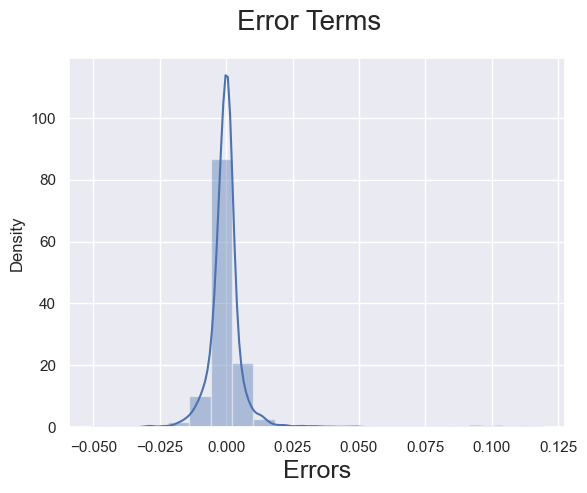

In [89]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

## Making Predictions

#### Applying the scaling on the test sets

In [90]:
num_vars = ['Strike_price', 'Spot_price', 'BidAsk', 'Diff(%)', 'Orders', 'Days_diff', 'Time_to_Expiry', 'Implied_Volatility', 'Option_call_price']

df_test[num_vars] = scaler.transform(df_test[num_vars])

#### Dividing into X_test and y_test

In [91]:
y_test = df_test.pop('Option_call_price')
X_test = df_test

In [92]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [93]:
# Making predictions
y_pred = lm.predict(X_test_new)

In [94]:
y_pred

3857    0.047319
2797    0.078318
3776    0.038480
39      0.064048
867     0.076305
4693    0.027799
3994    0.034860
4044    0.029031
446     0.045536
1536    0.046090
3247    0.008538
3539    0.002998
1888    0.132257
3881    0.050892
2072    0.798549
1332    0.013626
2172    0.076069
2307    0.088290
4340    0.088882
159     0.059555
651     0.058023
1196    0.010746
3795    0.074288
3381    0.097321
1695    0.048887
634     0.056320
4102    0.031799
134     0.050907
3428    0.058325
4330    0.311948
556     0.329582
1298    0.017108
3820   -0.012315
1702    0.008060
4590    0.041977
531     0.040518
2701    0.061927
3442    0.089020
4866    0.088047
2577    0.018582
4288    0.027724
2519    0.033870
878     0.010266
1787    0.095226
3532    0.022706
4441    0.043096
898     0.029551
2480    0.008416
1139    0.064493
4084    0.003146
1738    0.034947
1069    0.202164
3843    0.074942
1759    0.170451
4630    0.038586
2088    0.045289
2816    0.032109
3709    0.028199
4395    0.0506

In [95]:
y_pred.shape

(1516,)

In [96]:
y_test.shape

(1516,)

## Model Evaluation

Text(0, 0.5, 'y_pred')

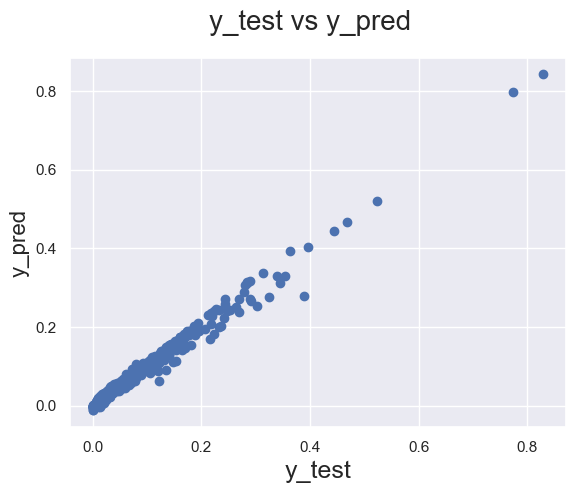

In [97]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [98]:
from sklearn.metrics import r2_score

In [99]:
# Evaluate the model to compute the R2
r2_score(y_true=y_test, y_pred=y_pred)

0.986189850927607

# Converting to pkl file

In [100]:
import pickle


In [101]:
pickle.dump(lm, open("model.pkl", "wb"))

In [102]:
lm = pickle.load(open("model.pkl", "rb"))

- 'Strike_price'
- 'Spot_price', (REMOVE)
- 'BidAsk', 
- 'Diff(%)', (REMOVE)
- 'Orders', (REMOVE)
- 'Days_diff', (REMOVE)
- 'Time_to_Expiry', 
- 'Implied_Volatility'

In [103]:
print(lm.predict([[110,100,0,0,0,0,0.5,0.2]]))

[10.43204443]


## Integrating with Postman

In [104]:
from flask import Flask, request, jsonify
from flask_cors import CORS
app = Flask(__name__)

CORS(app, origins=["http://example1.com"])
@app.route('/api/ml/predict', methods=['POST'])
def predict():
    data = request.json
    lm = pickle.load(open("model.pkl", "rb"))

    strike_price = data['strike_price']
    spot_price = data['spot_price']
    bid_ask = data['bid_ask']
    diff = data['diff']
    orders = data['orders']
    days_diff = data['days_diff']
    time_to_expiry = data['time_to_expiry']
    implied_volatility = data['implied_volatility']

    x = np.array([strike_price, spot_price, bid_ask, diff, orders, days_diff, time_to_expiry, implied_volatility])

    y_pred = lm.predict(x)

    return jsonify({'option_call_price': y_pred[0]})

In [ ]:
if __name__ == '__main__':
    pickle.dump(lm, open("model.pkl", "wb"))
    app.run(debug=True, use_reloader=False,port=5011)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5011
Press CTRL+C to quit


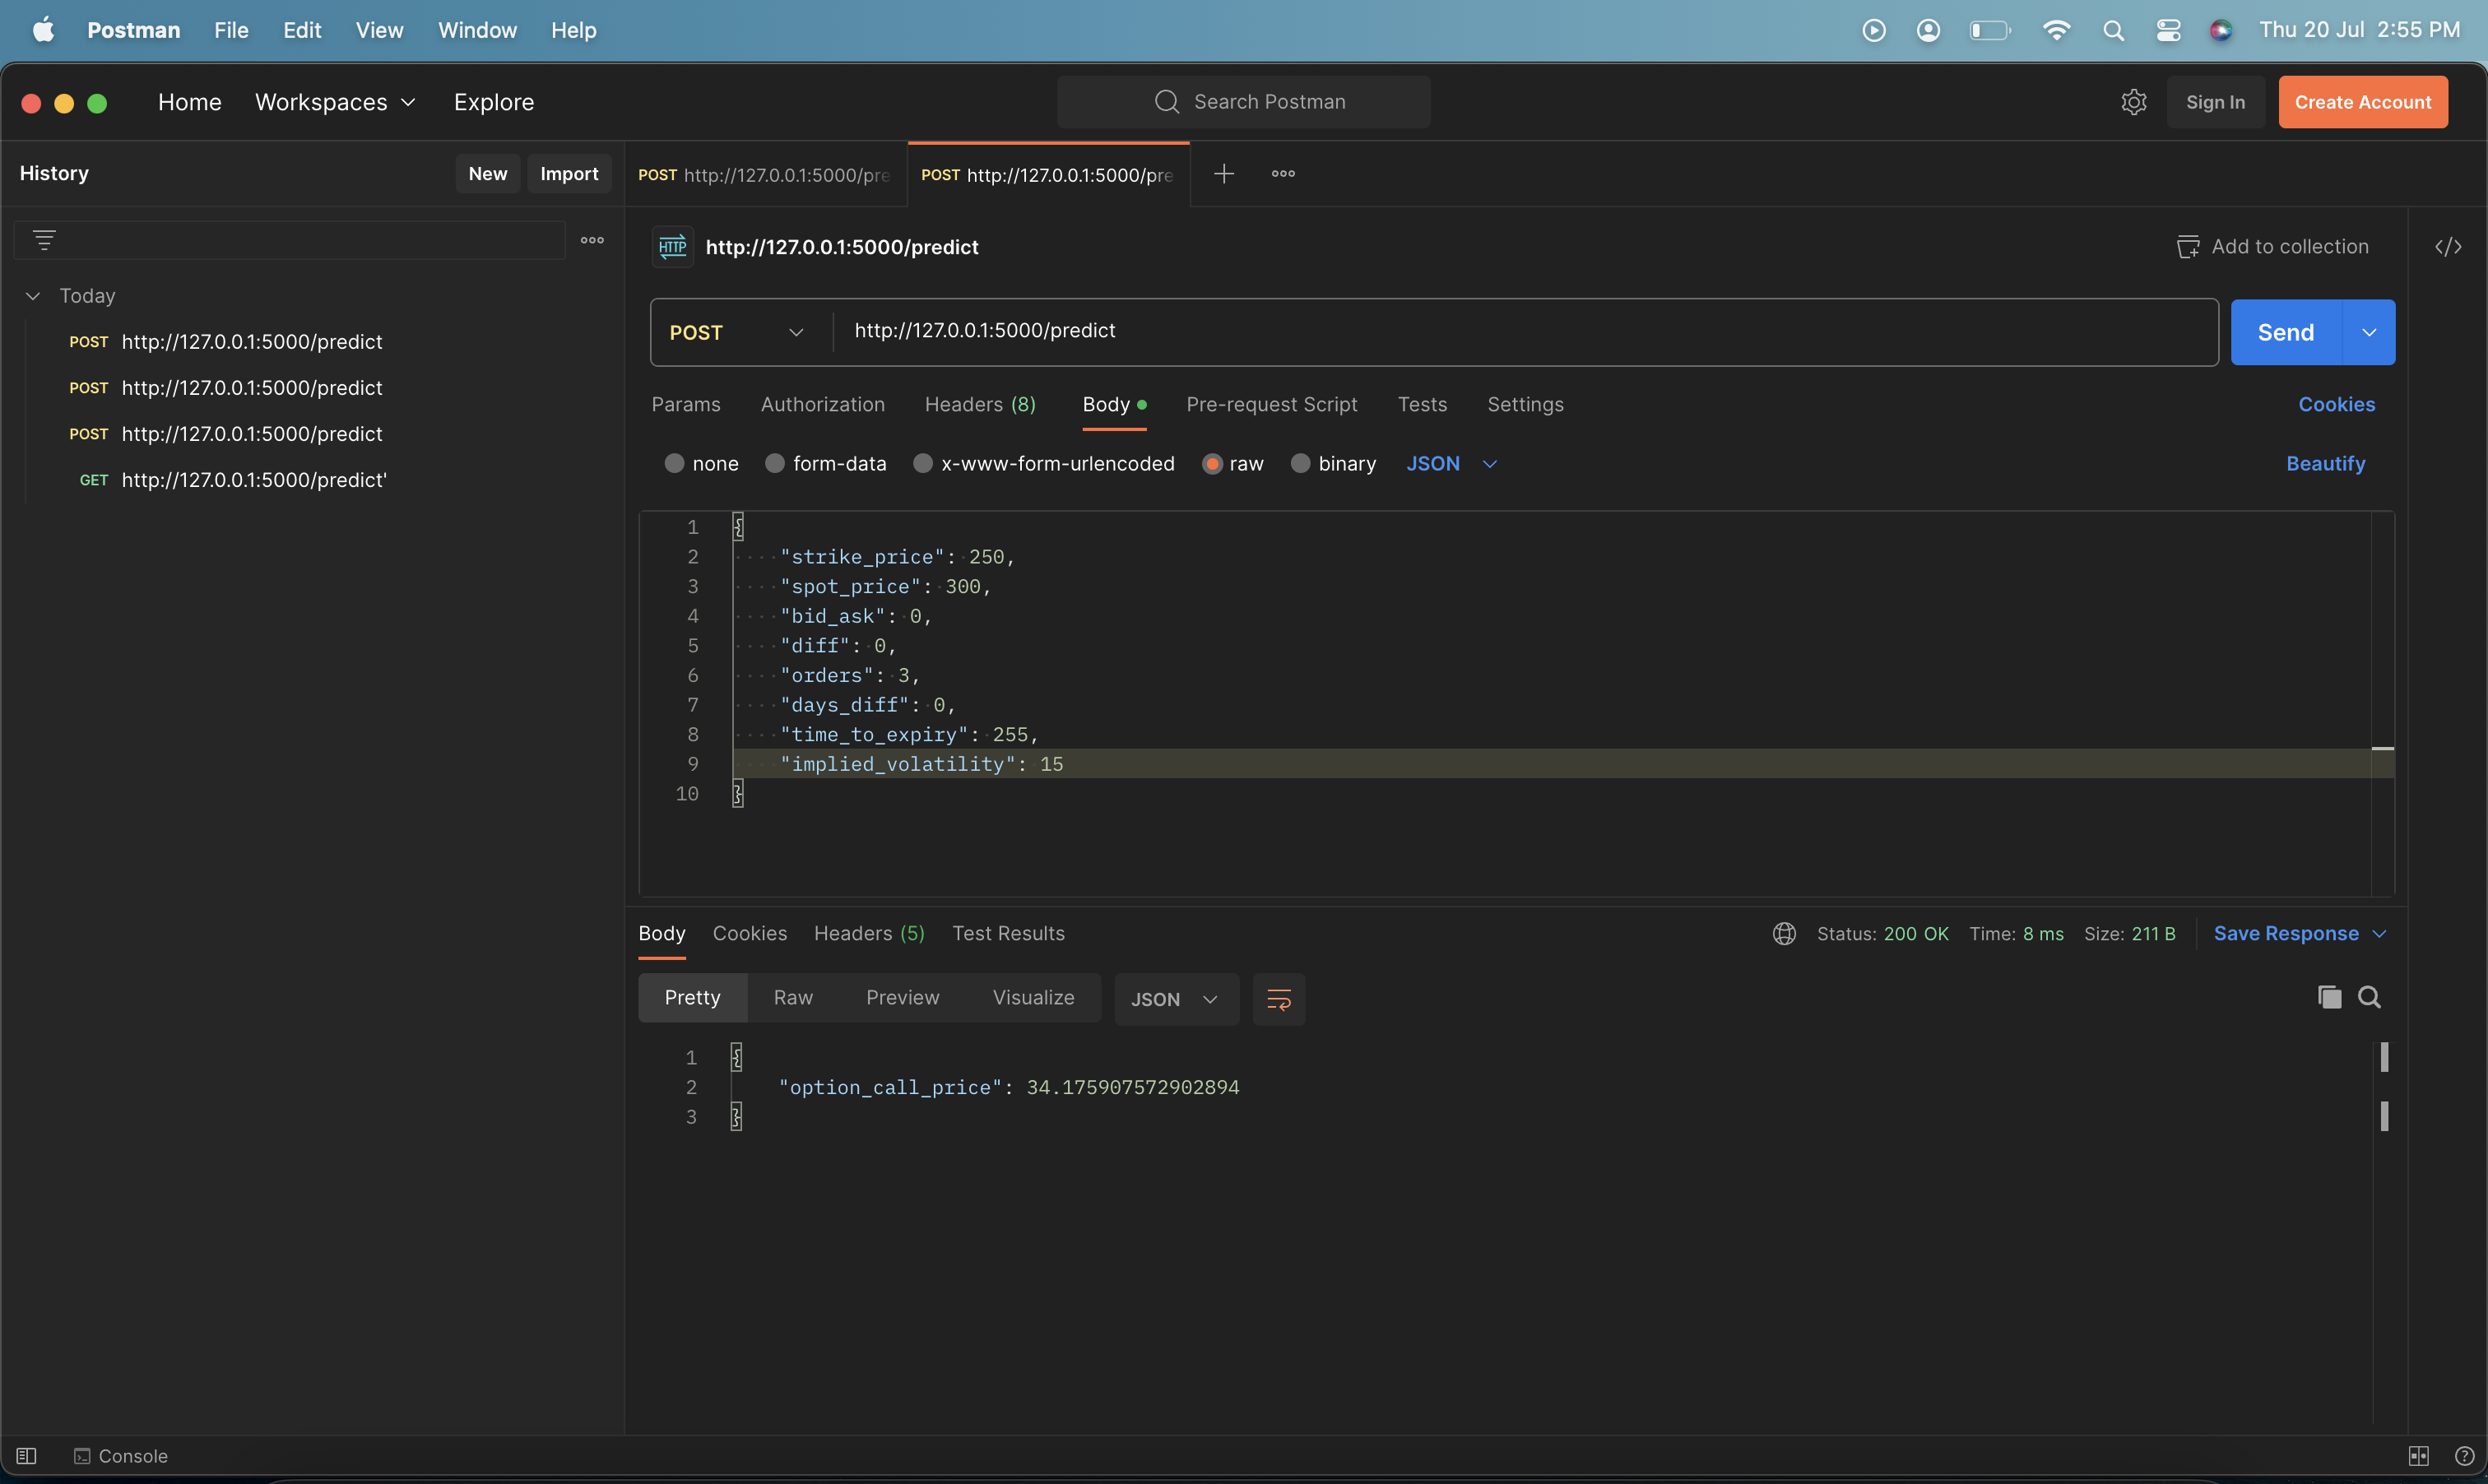

# Monte carlo simulation

import numpy as np

# Assuming the required inputs are available in your dataframe
expiry = df['Expiry']
strike_price = df['Strike_price']
spot_price = df['Spot_price']
risk_free_rate = 0.05  # Example risk-free rate
volatility = 0.2  # Example volatility

# Define the number of simulations and time steps
num_simulations = 1000
num_time_steps = 252  # Assuming daily time steps for one year

# Perform Monte Carlo simulation
option_prices = []
for _ in range(num_simulations):
    # Initialize the price trajectory with the spot price
    price_trajectory = [spot_price]

    for _ in range(num_time_steps):
        # Generate a random price change (log returns) from a normal distribution
        rand = np.random.normal(0, 1)
        price_change = risk_free_rate * expiry + volatility * np.sqrt(expiry) * rand

        # Calculate the next price based on the current price and price change
        next_price = price_trajectory[-1] * np.exp(price_change)
        price_trajectory.append(next_price)

    # Calculate the option call price at expiry using the last price in the trajectory
    call_price = np.maximum(price_trajectory[-1] - strike_price, 0)
    option_prices.append(call_price)

# Calculate the average option call price over all simulations
average_option_price = np.mean(option_prices)


X, y = df_call.iloc[:, :-1], df_call.iloc[:, -1]

print(X.shape)
print(y.shape)

X.head()

y.head()

from sklearn.model_selection import train_test_split
from sklearn import model_selection

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)

X_train.head()

y_train.head()

print(y.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

print(y_train.shape[0])
print(y_train[y_train==0].shape)
print(y_train[y_train==1].shape)

print(y_test.shape[0])
print(y_test[y_test==0].shape)
print(y_test[y_test==1].shape)

pip install xgboost

import xgboost as xgb
from sklearn import metrics

xgclf = xgb.XGBRegressor()

xgclf.fit(X_train, y_train)

df_call_train = df_call.iloc[:3550,:]
df_call_test = df_call.iloc[3550:,:]

df_call_train.shape

df_call_test.shape

df_call_train.head()

#### Visualizing the raw and the transformed data

# Plot
ls=['Strike_price','Spot_price','BidAsk', 'Diff(%)','Days_diff','Time_to_Expiry','Implied_Volatility','Option_call_price']
df=df_call_train[ls]
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(12,15))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

### Stationarity Test - ADF Test

for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(df_call_train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))

## VAR MODEL

exog = df_call_train['BidAsk']
mod = sm.tsa.VARMAX(df_call_train[['Implied_Volatility', 'Option_call_price']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

start_index = test.index.min()
end_index = test.index.max()
predictions = mod.fit().predict(start=start_index, end=end_index)

for i in range(predictions.shape[0]):
    if i==0:
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inv']=train.iloc[74,4]
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inc']=train.iloc[74,6]
    else:
        predictions.iloc[i,2]=predictions.iloc[i-1,4]
        predictions.iloc[i,3]=predictions.iloc[i-1,5]

    predictions['ln_inv']=(predictions['lag_ln_inv']+predictions['dln_inv'])
    predictions['ln_inc']=(predictions['lag_ln_inc']+predictions['dln_inc'])


    predictions['inv']=np.exp(predictions['ln_inv'])
    predictions['inc']=np.exp(predictions['ln_inc'])